In [1]:
import os
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import nltk

import gensim
from gensim.models import KeyedVectors

from keras import backend
from keras.utils import np_utils
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, GRU, GlobalMaxPooling1D, Dense
from keras import regularizers
from keras import metrics
from keras.utils.vis_utils import model_to_dot
import h5py

from IPython.display import SVG

Using TensorFlow backend.


In [2]:
INPUT_FILE = './text_for_gensim.txt'

In [3]:
WORD2VEC_MODEL = "./GoogleNews-vectors-negative300.bin"
VOCAB_SIZE = 10000
EMBEDDING_DIM = 300
NUM_FILTERS = 100
NUM_WORDS = 4
BATCH_SIZE = 300
NUM_EPOCHS = 3

**This takes the txt file, tokenizes the tweets, determines the max length of the tweets, and makes a counter for the corpus. Then it makes an index by going through the most common words of the 10,000 I'm setting vocab size to (this was a decision I made to remove words with low predictive power because they appear rarely) and assigns the words word IDs.**

In [4]:
counter = collections.Counter()
fin = open(INPUT_FILE, 'r')
maxlen = 0
for line in fin:
    _, sent = line.strip().split('\t')
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1
fin.close()

word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_size = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

**Here I make my dependent and independent variables, with the words in the dependent variable (tweets) tokenized. I also "pad" the tweets at 100 words. This will add zeros at the end of tweets less than 100 words, and cut off tweets longer than 100 words after the hundredth.**

In [5]:
xs, ys = [], []
fin = open(INPUT_FILE, 'r')
for line in fin:
    label, sent = line.strip().split('\t')
    ys.append(int(label))
    words = [x for x in nltk.word_tokenize(sent)]
    wids = [word2index[word] for word in words]
    xs.append(wids)
fin.close()
X = pad_sequences(xs, maxlen=100)
y = np_utils.to_categorical(ys)

In [6]:
print(y)

[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 ..., 
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


**In the next 2 cells I perform 2 splits. The first is 80:20. My lists of dependent variables (tweets) are split into 2 grourps, with the 80% group becoming my training data. In the second I split the 20% testing set in half. One half will be the validation data for the model, the other half will be used for predictions to get an F1 score.**

In [7]:
FIRST_VALIDATION_SPLIT = 0.2
SECOND_VALIDATION_SPLIT = 0.5
MAX_SEQUENCE_LENGTH = 100

In [8]:
first_indices = np.arange(X.shape[0])
np.random.shuffle(first_indices)
data = X[first_indices]
labels = y[first_indices]
nb_validation_samples_1 = int(FIRST_VALIDATION_SPLIT * data.shape[0])

X_train = data[:-nb_validation_samples_1]
y_train = labels[:-nb_validation_samples_1]
X_val_to_divide = data[-nb_validation_samples_1:]
y_val_to_divide = labels[-nb_validation_samples_1:]

second_indices = np.arange(X_val_to_divide.shape[0])
np.random.shuffle(second_indices)
X_val_to_divide = X_val_to_divide[second_indices]
y_val_to_divide = y_val_to_divide[second_indices]
nb_validation_samples_2 = int(SECOND_VALIDATION_SPLIT * X_val_to_divide.shape[0])

X_val = X_val_to_divide[:-nb_validation_samples_2]
y_val = y_val_to_divide[:-nb_validation_samples_2]
X_hold = X_val_to_divide[-nb_validation_samples_2:]
y_hold = y_val_to_divide[-nb_validation_samples_2:]

In [9]:
labels = to_categorical(np.asarray(y))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (24783, 100)
Shape of label tensor: (24783, 3, 2)


**Here I vectorize each word. Instead of a single word, each word becomes a 1x300 dimensional word vector with the keyedvectors gensim function, using the google news corpus. This is an example of transfer learning - where machine learning developed in one model is passed to a new model and improves it.**

In [13]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', 
                                                           binary=True)

embedding_weights = np.zeros((vocab_size, EMBEDDING_DIM))
for word, index in word2index.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [14]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [15]:
# This is a slightly modified implementation of a paper published at a conference in March 2018
# Title: Detecting Hate Speech on Twitter Using aConvolution-GRU Based Deep Neural Network
# Authors: Ziqi Zhang, David Robinson, and Jonathan Tepper
BATCH = 300

model = Sequential()

model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights=[embedding_weights]))

model.add(Dropout(0.2))

model.add(Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'))

model.add(MaxPooling1D(pool_size=4))

model.add(GRU(100, return_sequences=True))

model.add(GlobalMaxPooling1D(input_shape=(25, 100)))

model.add(Dense(3, activation='softmax', activity_regularizer=regularizers.l1_l2(0.01)))

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [17]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          3000300   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 100)          120100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 25, 100)           60300     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total para

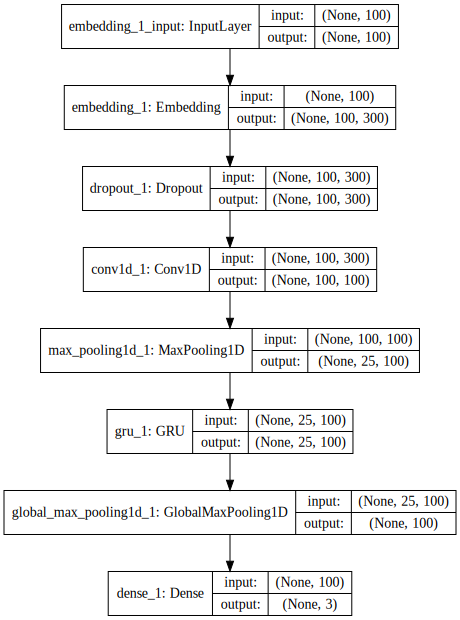

In [18]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


In [19]:
history = model.fit(X_train, y_train,
                    batch_size=BATCH,
                    epochs=10,
                    validation_data=(X_val, y_val))

Train on 19827 samples, validate on 2478 samples
Epoch 1/10
19827/19827 [==============================] - 27s 1ms/step - loss: 4.9171 - categorical_accuracy: 0.8373 - val_loss: 4.7909 - val_categorical_accuracy: 0.8910
Epoch 2/10
19827/19827 [==============================] - 28s 1ms/step - loss: 4.8702 - categorical_accuracy: 0.9027 - val_loss: 4.7838 - val_categorical_accuracy: 0.8943
Epoch 3/10
19827/19827 [==============================] - 28s 1ms/step - loss: 4.8569 - categorical_accuracy: 0.9218 - val_loss: 4.7781 - val_categorical_accuracy: 0.9052
Epoch 4/10
19827/19827 [==============================] - 27s 1ms/step - loss: 4.8471 - categorical_accuracy: 0.9379 - val_loss: 4.7777 - val_categorical_accuracy: 0.9068
Epoch 5/10
19827/19827 [==============================] - 27s 1ms/step - loss: 4.8391 - categorical_accuracy: 0.9507 - val_loss: 4.7773 - val_categorical_accuracy: 0.9052
Epoch 6/10
19827/19827 [==============================] - 28s 1ms/step - loss: 4.8327 - categori

In [20]:
model.save_weights('./hate_detector_trained.h5')

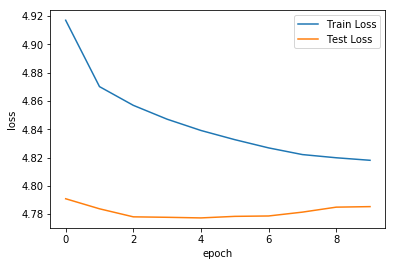

In [21]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.legend()
plt.show()

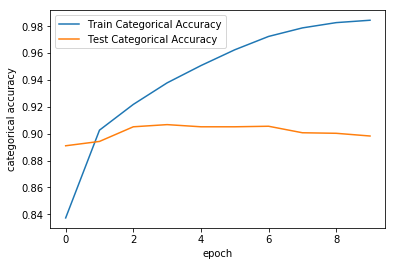

In [22]:
train_categorical_accuracy = history.history['categorical_accuracy']
test_categorical_accuracy = history.history['val_categorical_accuracy']
plt.ylabel('categorical accuracy')
plt.xlabel('epoch')
plt.plot(train_categorical_accuracy, label='Train Categorical Accuracy')
plt.plot(test_categorical_accuracy, label='Test Categorical Accuracy')
plt.legend()
plt.show()

In [23]:
model.evaluate(x=X_hold, y=y_hold, batch_size=300, verbose=0)

[4.7707153088244052, 0.91727199811335047]